In [ ]:
!nvidia-smi

Fri Nov 10 05:08:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <font color = 'pickle'>**Handling Long Sequence- Chunking** </font>

## <font color = 'pickle'> **Setting up the Environment** </font>

In [ ]:
from pathlib import Path
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate bitsandbytes -U -qq
    base_folder = Path("/content/drive/MyDrive/")


from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap
import warnings
warnings.filterwarnings('ignore')

# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'data'
model_folder = base_folder/'/models'
model_folder.mkdir(exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <font color = 'pickle'> **Function to Load Dataset**

In [ ]:
def load_custom_dataset(data_path, label_columns_name, text_column_name, class_names=None):
    from datasets import load_dataset
    dataset = load_dataset('csv', data_files=str(data_path))
    selected_columns = {
    'text': dataset['train'][text_column_name],
    'label': dataset['train'][label_columns_name]
    }

    # Create a new dataset with the selected columns
    dataset_selected_columns = Dataset.from_dict(selected_columns)
    dataset_selected_columns.set_format(type='pandas')
    df = dataset_selected_columns[:]
    df['text'] = df['text'].fillna('')
    dataset_selected_columns=dataset_selected_columns.from_pandas(df)

    # 1. Compute the class frequencies:
    class_weights = df['label'].value_counts(normalize=True, sort=False)

    # 2. Sort weights by index (i.e., by label):
    class_weights = class_weights.sort_index()

    # 3. Compute the inverse of the class frequencies:
    class_weights = 1/class_weights

    # 4. Normalize the weights so they sum up to 1 (this step is optional but can be useful):
    class_weights = class_weights / class_weights.sum()

    # 5. Convert the weights to a PyTorch tensor:
    class_tensor_weights = torch.tensor(class_weights.values, dtype=torch.float)

    if class_names:
        dataset_selected_columns = dataset_selected_columns.cast_column('label', ClassLabel(names = class_names))

    def filter_long_samples(example):
        return len(example['text'].split()) > 400

    stack_selected_columns_long = dataset_selected_columns.filter(filter_long_samples)
    return stack_selected_columns_long, class_tensor_weights


## <font color = 'pickle'> **Function to Split Dataset**
    


In [ ]:
def split_dataset(dataset, train_size, val_size, test_size):
    test_val_splits = dataset.train_test_split(train_size=train_size, seed=42, stratify_by_column='label')
    train_split= test_val_splits['train']
    test_size_new =test_size/(test_size + val_size)
    test_val_splits = test_val_splits['test'].train_test_split(test_size=test_size_new, seed=42, stratify_by_column='label')
    val_split = test_val_splits['train']
    test_split = test_val_splits['test']

    train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})
    test_dataset = DatasetDict({'test': test_split})

    return train_val_dataset, test_dataset

## <font color = 'pickle'> **Function to Create Small Subset**
    


In [ ]:
def get_small_subset(train_val_dataset, test_dataset, train_size, val_size, test_size):
    train_split_small = train_val_dataset['train'].shuffle(seed=42).select(range(train_size))
    val_split_small = train_val_dataset['val'].shuffle(seed=42).select(range(val_size))
    test_split_small = test_dataset['test'].shuffle(seed=42).select(range(test_size))

    # combine train, val splits into one dataset
    train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

    # create test dataset from test split
    test_subset= DatasetDict({'test': test_split_small})

    return train_val_subset, test_subset

## <font color = 'pickle'> **Function to Create Datasets**
    


In [ ]:
def setup_dataset(data_folder, class_names):

    # Constants for loading and splitting
    data_path = data_folder / 'multiclass_basic_clean.csv'
    label_columns_name = 'Tag_Number_final'
    text_column_name = 'basic_cleaned_text'

    # 1. Load Dataset
    dataset,class_tensor_weights = load_custom_dataset(data_path, label_columns_name, text_column_name, class_names=class_names)

    # 2. Split Dataset
    train_val_dataset, test_dataset = split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1)

    # 3. Get Small Balanced Subset
    train_val_subset, test_subset = get_small_subset(train_val_dataset, test_dataset,50,50,50)

    return train_val_dataset, test_dataset, class_tensor_weights ,train_val_subset, test_subset

## <font color = 'pickle'> **Function for Custom Collate**
    


In [ ]:
def collate_function(batch, tokenizer, max_length, stride):


    text_batch = [item.get('text','') for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None


    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result

## <font color = 'pickle'> **Function to Initialize Model**
    


In [ ]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
    return model

## <font color = 'pickle'> **Subclass Trainer**
    


In [ ]:
from transformers import Trainer
import torch
import torch.nn as nn
from transformers.trainer_utils import EvalPrediction
import torch.nn.functional as F

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="average_log_probs", class_weights=None, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(self.model.device)
        self.nll_loss = nn.NLLLoss(weight=self.class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
        doc_labels = inputs.pop("doc_labels", None)
        logits = model(**inputs).logits

        # convert logits to log probabilities, probabilities
        log_probabilities = F.log_softmax(logits, dim=-1)
        probabilities = F.softmax(logits, dim=-1)

        # Number of unique documents and chunks
        num_docs = doc_labels.size(0)
        num_chunks = overflow_to_sample_mapping.size(0)

        # Ensure overflow_to_sample_mapping is on the same device as doc_labels
        overflow_to_sample_mapping = overflow_to_sample_mapping.to(doc_labels.device)

        # Create a tensor representing each unique doc
        unique_docs = torch.arange(num_docs).to(doc_labels.device)

        # Create the mask
        mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

        if self.loss_type == "average_log_probs":
            avg_log_probs = (log_probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T
            loss = self.nll_loss(avg_log_probs, doc_labels)

        elif self.loss_type == "average_probs":
            avg_probs = (probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T
            avg_log_probs = torch.log(avg_probs)
            loss = self.nll_loss(avg_log_probs, doc_labels)

        elif self.loss_type == "max":
            max_values = torch.where(mask.unsqueeze(-1), log_probabilities[:, None, :], torch.tensor(float('-inf'), device=log_probabilities.device))
            max_log_probs = max_values.max(dim=0).values
            loss = self.nll_loss(max_log_probs, doc_labels)

        elif self.loss_type == "loss_per_chunk":
            loss = self.nll_loss(log_probabilities, labels.view(-1))

        else:
            raise ValueError(f"Unsupported loss_type: {self.loss_type}")

        return (loss, logits) if return_outputs else loss

## <font color = 'pickle'> **Function for Aggregate Prediction**
    


In [ ]:
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp

def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)
    return log_softmax


def aggregate_predictions (logits, aggregation_method, overflow_to_sample_mapping):

    probabilities = softmax(logits, axis=-1)
    log_probabilities = stable_log_softmax(logits)

    # print('log_probs', log_probabilities.shape)
    # print('overflow_to_sample_mapping', overflow_to_sample_mapping.shape)

    # Get unique documents

    unique_docs, inverse_indices = np.unique(overflow_to_sample_mapping, return_inverse=True)
    num_docs = unique_docs.size

    # Create a mask for documents
    mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

    # Initialize the aggregated_predictions variable
    aggregated_predictions = None

    if aggregation_method == "average_log_probs":
        # Compute average probabilities using NumPy
        avg_log_probs = (log_probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_log_probs, axis=-1)
        scores = np.exp(avg_log_probs.max(axis=-1))

    elif aggregation_method == "average_probs":
        # Compute average probabilities using NumPy
        avg_probs = (probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_probs, axis=-1)
        scores  = avg_probs.max(axis=-1)

    elif aggregation_method == "max_probs":
        # Compute max probabilities per document
        max_values = np.where(mask[:, :, None], log_probabilities[:, None, :], float('-inf'))
        max_log_probs = np.max(max_values, axis=0)
        aggregated_predictions = np.argmax(max_log_probs, axis=-1)
        scores = np.exp(max_log_probs.max(axis=-1))

    elif aggregation_method == "majority_vote":
        # Convert logits to actual predictions before voting
        predictions = np.argmax(logits, axis=1)
        # Tally the votes for each document
        vote_tally = np.zeros((num_docs, logits.shape[-1]), dtype=int)
        np.add.at(vote_tally, overflow_to_sample_mapping, np.eye(logits.shape[-1], dtype=int)[predictions])
        # Determine the majority vote for each document
        aggregated_predictions = np.argmax(vote_tally, axis=1)
        scores = vote_tally.max(axis=-1) / vote_tally.sum(axis=-1)
    else:
        raise ValueError(f"Unsupported aggregation_method: {aggregation_method}")

    # # Calculate evaluation metrics using document-level labels
    # metrics = evaluate.combine([
    #     evaluate.load("accuracy"),
    #     evaluate.load("f1", average="macro")
    # ])
    # evaluations = metrics.compute(predictions=aggregated_predictions, references=doc_labels)

    # return evaluations

    return aggregated_predictions, scores


## <font color = 'pickle'> **Function for Evaluation**
    


In [ ]:
from torch.utils.data import DataLoader
from transformers import PreTrainedModel
from evaluate import load

def evaluate_model(dataloader: DataLoader, model: PreTrainedModel, metric_only: bool = True, aggregation_method: str ='average_log_probs'):
    # Load the accuracy metric
    accuracy_metric = load("accuracy")
    f1_macro_metric = load("f1")
    f1_weighted_metric = load("f1")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)

    predictions = []
    all_doc_labels = []

    # Loop over batches
    for batch in dataloader:
        model.eval()
        doc_labels = batch.pop("doc_labels", None).cpu().numpy()
        overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping", None).cpu().numpy()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits.cpu().numpy()
            aggregated_predictions, scores = aggregate_predictions(logits=logits,
                                                            aggregation_method=aggregation_method,
                                                            overflow_to_sample_mapping=overflow_to_sample_mapping)

            accuracy_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            f1_macro_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            f1_weighted_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            if not metric_only:
                predictions.extend(aggregated_predictions)
                all_doc_labels.extend(doc_labels)

    # Calculate and return the final accuracy.
    final_accuracy = accuracy_metric.compute()['accuracy']
    f1_macro = f1_macro_metric.compute(average = 'macro')['f1']
    f1_weighted = f1_weighted_metric.compute(average = 'weighted')['f1']

    metrics = {
        "accuracy": final_accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
        }

    if metric_only:
        return metrics
    else:
        return metrics, predictions, all_doc_labels

## <font color = 'pickle'> **Function to plot confusion matrix**
    


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def log_and_plot_confusion_matrix(val_labels, val_predictions, class_names):
    cm = confusion_matrix(val_labels, val_predictions,normalize='true')

    # Plotting the confusion matrix
    plt.figure(figsize=(8,6))
    ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # Ensure x-labels are vertical
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Ensure y-labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## <font color = 'pickle'> **Function to free memory**
    


In [ ]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()


## Function to tokenize dataset and, train and eval models

In [ ]:
from functools import partial
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                                train_val_subset, class_tensor_weights):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_course-HW7-Part-B

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder/'models/stack/checkpoint'
    model_folder.mkdir(exist_ok=True,parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 4. Initialize Model and Tokenizer
    model = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 100)
    trainer = CustomTrainer(
        loss_type = "average_log_probs",
        # loss_type = "average_probs",
        # loss_type = "max",
        # loss_type = "loss_per_chunk",
        class_weights=class_tensor_weights,
        model=model,
        args=training_args,
        train_dataset=train_val_subset["train"],
        eval_dataset=train_val_subset["val"],
        data_collator=collate_fn,
        tokenizer=tokenizer,
        )

    # 6. Train and Evaluate
    trainer.train()
    train_metrics = evaluate_model(trainer.get_test_dataloader(train_val_subset['train']), model, metric_only=True)
    val_metrics, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val_subset['train']), model, metric_only=False)

    # 7. Log Metrics and Plot
    log_and_plot_confusion_matrix(val_labels, val_predictions, class_names)
    # log the Confusion Matrix to Wandb
    wandb.log({"conf_mat": wandb.plot.confusion_matrix(preds=val_predictions, y_true=val_labels,class_names=class_names)})

    print(f"Train Metrics: {train_metrics}")
    print(f"Validation Metrics: {val_metrics}")

    # best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    # wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    # print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()


## Initial Training Arguments

DO NOT CHANGE ANY ARGUMENTS

In [ ]:
# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16= True, # Use mixed precision training for memroy optimization
    # argument for EvalPred to include inputs and outputs
    remove_unused_columns=False,
    gradient_checkpointing=True,
    # torch_compile=True,


    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 20 training steps
    # save_strategy="steps",  # Save model checkpoint at specified step intervals
    # save_steps=50,  # Save a model checkpoint every 20 training steps
    # load_best_model_at_end=True,  # Reload the best model at the end of training
    # save_total_limit=1, # Retain only the best and the most recent model checkpoints

    # Use 'accuracy' as the metric to determine the best model
    # metric_for_best_model="accuracy",
    # greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='stack_long_seq_imbalance',  # Experiment name for Weights & Biases
)

# Experiments

## Dataset hyperparameters

In [ ]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']
train_val_dataset, test_dataset,class_tensor_weights,train_val_subset, test_subset = setup_dataset(data_folder,class_names)

Casting the dataset:   0%|          | 0/188878 [00:00<?, ? examples/s]

Filter:   0%|          | 0/188878 [00:00<?, ? examples/s]

In [ ]:
train_val_dataset, test_dataset,class_tensor_weights,train_val_subset, test_subset

(DatasetDict({
     train: Dataset({
         features: ['text', 'label'],
         num_rows: 3817
     })
     val: Dataset({
         features: ['text', 'label'],
         num_rows: 477
     })
 }),
 DatasetDict({
     test: Dataset({
         features: ['text', 'label'],
         num_rows: 478
     })
 }),
 tensor([0.0864, 0.0834, 0.0646, 0.0791, 0.0396, 0.0701, 0.1296, 0.1194, 0.1576,
         0.1700]),
 DatasetDict({
     train: Dataset({
         features: ['text', 'label'],
         num_rows: 50
     })
     val: Dataset({
         features: ['text', 'label'],
         num_rows: 50
     })
 }),
 DatasetDict({
     test: Dataset({
         features: ['text', 'label'],
         num_rows: 50
     })
 }))

## Experiment 1 : distilbert-base-uncased with 3817 sample size
per_device_eval_batch_size=8, per_device_train_batch_size=8, and gradient_accumulation_steps=2,epochs = 1

### Trainer hyperparameters

In [ ]:
checkpoint = "distilbert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{3817}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

wandb: Currently logged in as: akshat_patil. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course-HW7-Part-B


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
20,2.234100,2.148221
40,2.130800,2.007630
60,1.929000,1.779286
80,1.751100,1.603490
100,1.603200,1.457784
120,1.416500,1.352330
140,1.350300,1.262330
160,1.219400,1.190571
180,1.211200,1.125129
200,1.089300,1.096805


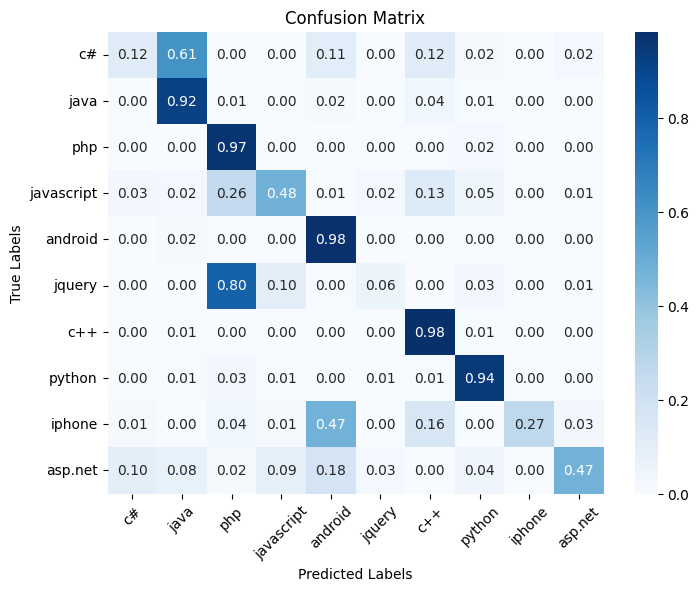

Train Metrics: {'accuracy': 0.7791459261199896, 'f1_macro': 0.6112439567870334, 'f1_weighted': 0.7329096662540521}
Validation Metrics: {'accuracy': 0.7791459261199896, 'f1_macro': 0.6112439567870334, 'f1_weighted': 0.7329096662540521}


eval/loss,█▇▆▄▄▃▂▂▁▁▁
eval/runtime,▁▇▂▂▂▄█▃▃▃▃
eval/samples_per_second,█▂▇▇▆▄▁▆▆▆▆
eval/steps_per_second,█▂▇▇▆▄▁▆▆▆▆
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
train/learning_rate,█▇▇▆▅▅▄▃▂▂▁
train/loss,█▇▆▅▄▃▃▂▂▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(new_training_args, checkpoint, base_folder,train_val_dataset, class_tensor_weights)

## Experiment 2 : distilbert-base-uncased with 3817 sample size
per_device_eval_batch_size=8, per_device_train_batch_size=8, and gradient_accumulation_steps=4,epochs = 1

### Trainer hyperparameters

In [ ]:
checkpoint = "distilbert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{3817}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

env: WANDB_PROJECT=nlp_course-HW7-Part-B


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
20,2.228900,2.114640
40,2.049300,1.911504
60,1.832800,1.685907
80,1.636300,1.523634
100,1.489900,1.438852


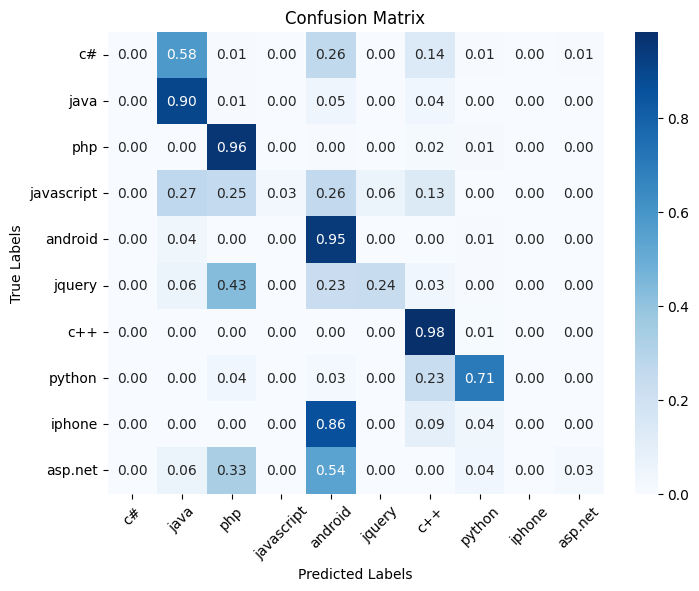

Train Metrics: {'accuracy': 0.7070998166099031, 'f1_macro': 0.4395096836866065, 'f1_weighted': 0.6238494539529748}
Validation Metrics: {'accuracy': 0.7070998166099031, 'f1_macro': 0.4395096836866065, 'f1_weighted': 0.6238494539529748}


eval/loss,█▆▄▂▁
eval/runtime,▁▆▆██
eval/samples_per_second,█▃▃▁▁
eval/steps_per_second,█▃▃▁▁
train/epoch,▁▁▂▂▄▄▅▅▇▇█
train/global_step,▁▁▂▂▄▄▅▅▇▇██
train/learning_rate,█▆▄▃▁
train/loss,█▆▄▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(new_training_args, checkpoint, base_folder,train_val_dataset, class_tensor_weights)

# Conclusion
In conducting two experiments on a multiclass classification task for longer sequence, Experiment 1, characterized by a smaller effective batch size and fewer gradient accumulation steps, outperformed Experiment 2 in terms of accuracy, f1_macro, and f1_weighted metrics. The superior performance of Experiment 1 suggests that a more nuanced handling of the imbalanced dataset was achieved, reflected in higher sensitivity to minority classes. Both experiments benefited from advanced training techniques such as mixed precision training (fp16) and gradient checkpointing, highlighting the importance of modern practices in optimizing deep learning model training. While these results showcase the efficacy of Experiment 1, further exploration with diverse hyperparameter configurations, including two epochs, and a different model (bert-base-uncased) is done in the additional experiments to see if we can get an increase in the accuracy and f1_macro scores.





## Experiment 3 : distilbert-base-uncased
2 epochs  gradient_accumulation_steps=2

### Trainer hyperparameters

In [ ]:
checkpoint = "distilbert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{3817}-2epochs' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

wandb: Currently logged in as: akshat_patil. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course-HW7-Part-B


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
20,2.236300,2.142621
40,2.115500,1.987993
60,1.896800,1.737291
80,1.709200,1.514506
100,1.494100,1.328156
120,1.279300,1.195200
140,1.227600,1.104616
160,1.070300,0.986245
180,1.019100,0.916849
200,0.836800,0.863207


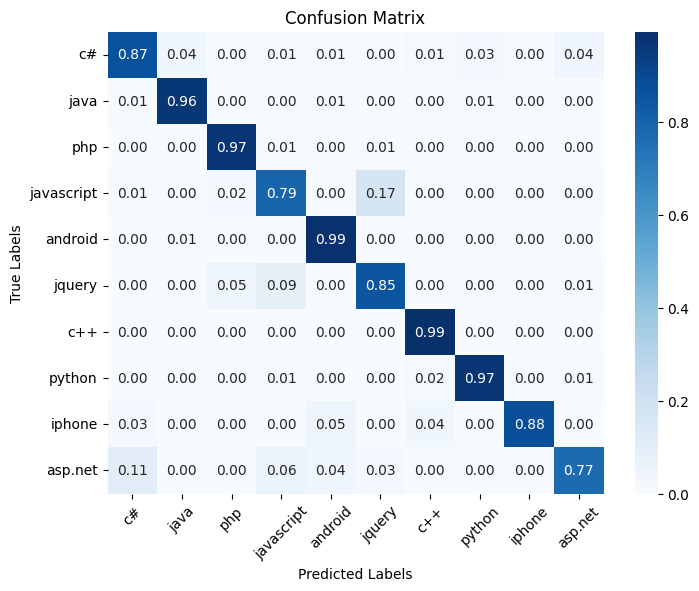

Train Metrics: {'accuracy': 0.9428870840974587, 'f1_macro': 0.909241794613717, 'f1_weighted': 0.9425478876587784}
Validation Metrics: {'accuracy': 0.9428870840974587, 'f1_macro': 0.909241794613717, 'f1_weighted': 0.9425478876587784}


eval/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▃▄▄▄▄▄▄▄▄█▄▄▄▅▅▅▄▄▅▅▅
eval/samples_per_second,▁█▆▅▅▅▅▅▅▅▄▁▅▅▅▄▄▄▅▅▄▄▃
eval/steps_per_second,▁█▆▅▅▅▅▅▅▅▄▁▅▅▅▄▄▄▅▅▄▄▃
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(new_training_args, checkpoint, base_folder,train_val_dataset, class_tensor_weights)

## Experiment 4 : distilbert-base-uncased
2 epochs  gradient_accumulation_steps=4

### Trainer hyperparameters

In [ ]:
checkpoint = "distilbert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{3817}-2epochs' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

env: WANDB_PROJECT=nlp_course-HW7-Part-B


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
20,2.198200,2.081406
40,1.996600,1.832880
60,1.733600,1.551164
80,1.497500,1.360465
100,1.288100,1.197248
120,1.192600,1.079965
140,1.041000,0.991629
160,0.990900,0.918664
180,0.913400,0.876500
200,0.901200,0.844422


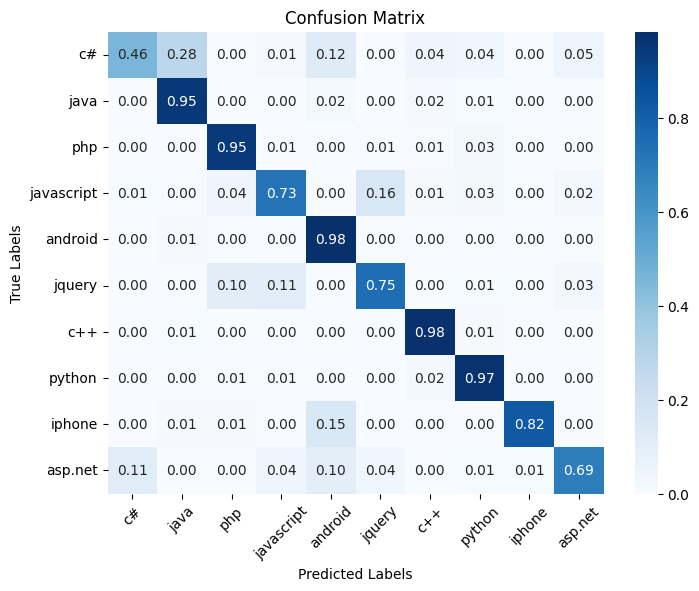

Train Metrics: {'accuracy': 0.8862981399004454, 'f1_macro': 0.8335169118092554, 'f1_weighted': 0.8791950388019903}
Validation Metrics: {'accuracy': 0.8862981399004454, 'f1_macro': 0.8335169118092554, 'f1_weighted': 0.8791950388019903}


eval/loss,█▇▅▄▃▂▂▂▁▁▁
eval/runtime,▁█▅█▇▇▇▇▇▇▇
eval/samples_per_second,█▁▄▁▂▂▂▂▂▂▂
eval/steps_per_second,█▁▄▁▂▂▂▂▂▂▂
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
train/learning_rate,█▇▇▆▅▄▄▃▂▂▁
train/loss,█▇▆▄▃▃▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(new_training_args, checkpoint, base_folder,train_val_dataset, class_tensor_weights)

## Experiment 5 : bert-base-uncased

### Trainer hyperparameters

In [ ]:
checkpoint = "bert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{3817}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

env: WANDB_PROJECT=nlp_course-HW7-Part-B


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,2.268100,2.187834
40,2.129000,2.014537
60,2.001600,1.894193
80,1.904300,1.811869
100,1.801200,1.724657
120,1.642400,1.557206
140,1.586700,1.443697
160,1.486500,1.348230
180,1.419100,1.266024
200,1.263800,1.221861


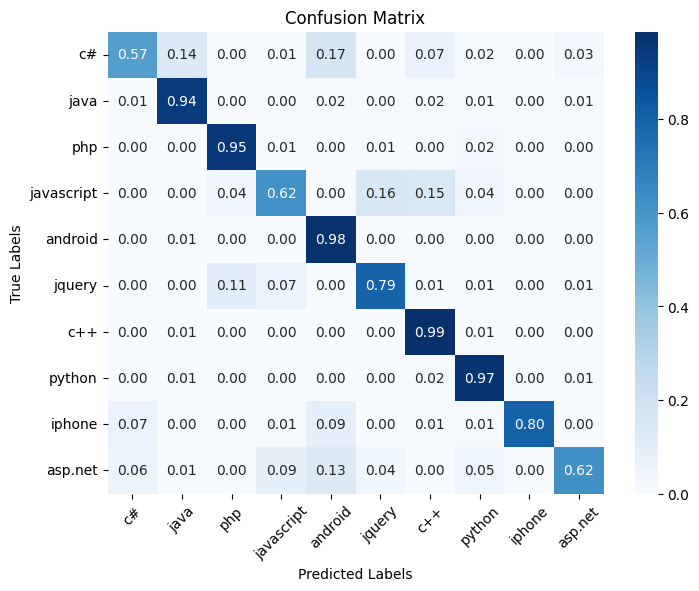

Train Metrics: {'accuracy': 0.8878700550170291, 'f1_macro': 0.8366657763741212, 'f1_weighted': 0.8818913695990467}
Validation Metrics: {'accuracy': 0.8878700550170291, 'f1_macro': 0.8366657763741212, 'f1_weighted': 0.8818913695990467}


eval/loss,█▇▆▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
eval/runtime,▁▂▄▅▅▆▅▅▆█▅▆▆▅▆▆▆▆█▆▆▅▅
eval/samples_per_second,█▆▅▄▃▃▄▃▃▁▄▃▃▃▃▃▃▃▁▃▃▄▄
eval/steps_per_second,█▆▅▄▃▃▄▃▃▁▄▃▃▃▃▃▃▃▁▃▃▄▄
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
train/loss,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁▂▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(new_training_args, checkpoint, base_folder,train_val_dataset, class_tensor_weights)